In [1]:
# for data importing and storing
import numpy as np
import pandas as pd
import os

# for plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# for cohen's d function:
from statistics import mean, stdev
from math import sqrt

# for statistical analysis
from scipy import stats


#######################################SPEED

def speed(x, y, fps, pxPerCm):
    distance_between_frames = ((x.diff(-1) ** 2 + y.diff(-1) **2) ** 0.5) * fps / pxPerCm # multiply by frames per second to get pixel per second
    return np.mean(distance_between_frames)

#######################################FREEZING

def freeze(x,y, cut_off_for_freezing, time_for_freezing): # cut_off_for_freezing and time_for_freezing in pixels and frames, respectively
    distance_between_frames = ((x.diff(-1) ** 2 + y.diff(-1) **2) ** 0.5)
    potential_freezes = pd.DataFrame(distance_between_frames <= cut_off_for_freezing)
    potential_freezes.columns = ['freeze']
    potential_freezes['true_freeze'] = potential_freezes['freeze'].groupby((~potential_freezes['freeze']).cumsum()).cumsum()
    ids = potential_freezes['true_freeze'] == 0
    if ids[0] == 1:
        ids[0] == 0
    res = [i for i, val in enumerate(ids) if val]
    time_spent_freezing = 0
    for item in res:
        if item > 0:
            if potential_freezes['true_freeze'][item - 1] > time_for_freezing:
                if potential_freezes['freeze'][item] == 0:
                    time_spent_freezing += potential_freezes['true_freeze'][item - 1]
    time_spent_freezing = time_spent_freezing / len(potential_freezes) * 100
    return time_spent_freezing  

#######################################SAVING_DATA

cols = ['age', 'genotype', 'condition', 'phase', 'experiment', 'fish', 'speed', 'freezing', 'ID']
results_df = pd.DataFrame(columns = cols) # results are pre-initiated, important to run this box for every run!

def save_data(age, genotype, condition, phase, experiment, fish, speed, freezing, results_df):
    results_df_2 = pd.DataFrame({'age': age,
                                 'genotype': genotype,
                                 'condition': condition,
                                 'phase': phase,
                                 'experiment': experiment.split('.')[0],
                                 'ID': str(age + genotype + condition + experiment.split('.')[0] + '_' + str(fish)),
                                 'fish': fish,                              
                                 'speed': [speed],
                                 'freezing': [freezing]
                                         })
    results_df = results_df.append(results_df_2)
    return results_df

   
##########################################Calculate effect size: cohen's d
def cohend(x,y):
    cohens_d = (mean(x) - mean(y)) / (sqrt((stdev(x) ** 2 + stdev(y) ** 2) / 2))
    return cohens_d

In [3]:
file_location = 'C:\\Users\\anneserl\\Desktop\\AnG_Lukas'

for file in os.listdir(file_location): # 
   # print(file)
    age, genotype, condition, phase, experiment = file.split('_')
    
    # select corresponding features:
    # Frames per second ####################
    if age == 14:
        fps = 30
        if genotype == "oxtr":
            if condition == "iso":
                fps = 20
            if condition == "soc":
                if phase == "H":
                    if experiment == "1":
                        fps = 20
    else:
        fps = 20
    ########################################  
    # Pixel per centimeter##################
    if age == 56:
        pxPerCm = 100
    else:
        pxPerCm = 75       
    
    
    df = pd.read_csv(file_location + '\\' + file ,
                    header = None)    
    n_fish = len(df.columns) // 2
    for fish in range(n_fish):
        x = df[fish * 2]
        y = df[fish * 2 +1]
        # get bbox:
       # x1, x2, y1, y2 = bbox(fish+1, age , genotype, condition, experiment)
        #print(file + ': fish ' + str(fish + 1))
        #if phase == 'H':
        #    draw_fish(x1,x2,y1,y2, x,y)
               
        speed_average = speed(x , y, fps, pxPerCm)
        freezing = freeze(x,y, 0, fps*5) # no movement , 5 seconds
        
        results_df = save_data(age, genotype, condition, phase, experiment, fish, speed_average, freezing, results_df) 

# additional column for easier indexing:       
results_df['condition_phase'] = results_df['condition'] + results_df['phase']
results_df['genotype'] = results_df['genotype'].astype('category')
results_df['genotype'].cat.reorder_categories(['wt', 'oxtr', 'oxtrl'], inplace = True)# necessary for correct plotting order  

C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


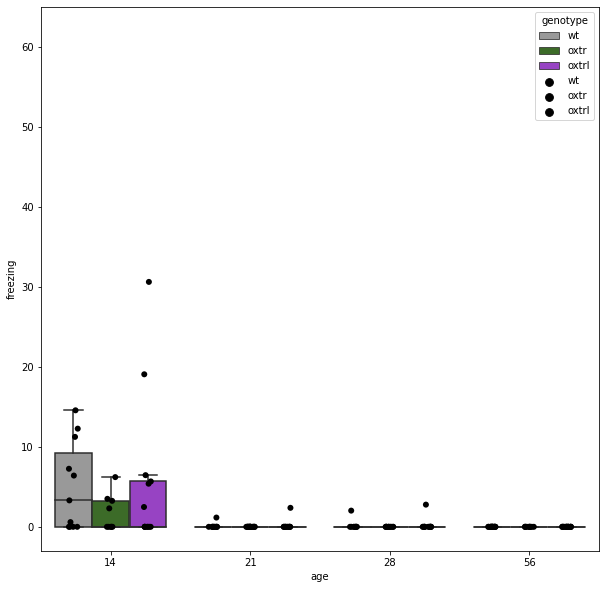

In [13]:
# comment out/in what you are interested in

idx = results_df['condition_phase'] == "isoH"

#idx = results_df['condition_phase'] == "isoT"

#idx = results_df['condition_phase'] == "socH"

#idx = results_df['condition_phase'] == "socT"

subset = results_df[idx] # subset the initital dataframe to enable plotting

# get colors for plotting - feel free to change to correct hex-code
muted    = ["#999999", "#38761d" , "#9e2ed8"]
newPal   = dict(wt = muted[0], oxtr = muted[1], oxtrl = muted[2])
newPal2 = dict(wt = "#000000" , oxtr = "#000000", oxtrl = "#000000")

# plot the figure
fig, ax = plt.subplots(figsize = (10,10))
ax = sns.boxplot(x="age", y="freezing", data=subset, hue = "genotype", fliersize = np.nan, palette=newPal)
ax = sns.stripplot(x="age", y="freezing", data=subset, hue = 'genotype', dodge = True , edgecolor='gray', size = 6, palette = newPal2)
#ax.set_ylim(0, 8.5) # for plotting speed
ax.set_ylim(-3, 65) # for plotting freezing
plt.savefig('isoH_freezing.svg') # to save the figure as .svg

In [20]:
results_df.to_csv('results_socialPreferenceLocomotion.csv') # for 

In [11]:
# Statistical Analysis

############
# FREEZING #
############

print('Analysis of freezing behavior')

print('Analysis of animals during habituation phase')
subset = results_df[results_df['phase']=='H']

# 14 dpf - All 2 wpf, socially reared:
df_14dpf = subset[subset['age'] == '14']
df_14dpf_soc = df_14dpf[df_14dpf['condition'] == 'soc']
print('at 14 dpf, for socially reared animals, kruskal wallis results in: ')
wt = df_14dpf_soc[df_14dpf_soc['genotype']=='wt']['freezing']
oxtr = df_14dpf_soc[df_14dpf_soc['genotype']=='oxtr']['freezing']
oxtrl = df_14dpf_soc[df_14dpf_soc['genotype']=='oxtrl']['freezing']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')

if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')


# 14 dpf - All 2 wpf, isolation reared:
df_14dpf_iso = df_14dpf[df_14dpf['condition'] == 'iso']
print('at 14 dpf, for isolation reared animals, kruskal wallis results in: ')
wt = df_14dpf_iso[df_14dpf_iso['genotype']=='wt']['freezing']
oxtr = df_14dpf_iso[df_14dpf_iso['genotype']=='oxtr']['freezing']
oxtrl = df_14dpf_iso[df_14dpf_iso['genotype']=='oxtrl']['freezing']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')

if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 21 dpf - All 3 wpf, socially reared:
df_21dpf = subset[subset['age'] == '21']
df_21dpf_soc = df_21dpf[df_21dpf['condition'] == 'soc']
print('at 21 dpf, for socially reared animals, kruskal wallis results in: ')
wt = df_21dpf_soc[df_21dpf_soc['genotype']=='wt']['freezing']
oxtr = df_21dpf_soc[df_21dpf_soc['genotype']=='oxtr']['freezing']
oxtrl = df_21dpf_soc[df_21dpf_soc['genotype']=='oxtrl']['freezing']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')

if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 21 dpf - All 3 wpf, isolation reared:
df_21dpf_iso = df_21dpf[df_21dpf['condition'] == 'iso']
print('at 21 dpf, for isolation reared animals, kruskal wallis results in: ')
wt = df_21dpf_iso[df_21dpf_iso['genotype']=='wt']['freezing']
oxtr = df_21dpf_iso[df_21dpf_iso['genotype']=='oxtr']['freezing']
oxtrl = df_21dpf_iso[df_21dpf_iso['genotype']=='oxtrl']['freezing']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')

if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 28 dpf - All 4 wpf, socially reared:
df_28dpf = subset[subset['age'] == '28']
df_28dpf_soc = df_28dpf[df_28dpf['condition'] == 'soc']
print('at 28 dpf, for socially reared animals, kruskal wallis results in: ')
wt = df_28dpf_soc[df_28dpf_soc['genotype']=='wt']['freezing']
oxtr = df_28dpf_soc[df_28dpf_soc['genotype']=='oxtr']['freezing']
oxtrl = df_28dpf_soc[df_28dpf_soc['genotype']=='oxtrl']['freezing']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')

if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 21 dpf - All 3 wpf, isolation reared:
df_28dpf_iso = df_28dpf[df_28dpf['condition'] == 'iso']
print('at 28 dpf, for isolation reared animals, kruskal wallis results in: ')
wt = df_28dpf_iso[df_28dpf_iso['genotype']=='wt']['freezing']
oxtr = df_28dpf_iso[df_28dpf_iso['genotype']=='oxtr']['freezing']
oxtrl = df_28dpf_iso[df_28dpf_iso['genotype']=='oxtrl']['freezing']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')

if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 56 dpf - All 8 wpf, socially reared:
df_56dpf = subset[subset['age'] == '56']
df_56dpf_soc = df_56dpf[df_56dpf['condition'] == 'soc']
print('at 56 dpf, for socially reared animals, kruskal wallis results in: ')
wt = df_56dpf_soc[df_56dpf_soc['genotype']=='wt']['freezing']
oxtr = df_56dpf_soc[df_56dpf_soc['genotype']=='oxtr']['freezing']
oxtrl = df_56dpf_soc[df_56dpf_soc['genotype']=='oxtrl']['freezing']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')

if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 56 dpf - All 8 wpf, isolation reared:
df_56dpf_iso = df_56dpf[df_56dpf['condition'] == 'iso']
print('at 56 dpf, for isolation reared animals, kruskal wallis results in: ')
wt = df_56dpf_iso[df_56dpf_iso['genotype']=='wt']['freezing']
oxtr = df_56dpf_iso[df_56dpf_iso['genotype']=='oxtr']['freezing']
oxtrl = df_56dpf_iso[df_56dpf_iso['genotype']=='oxtrl']['freezing']
# perform Kruskal-Wallis Test 
try:
    F, p = stats.kruskal(wt, oxtr, oxtrl)
except ValueError:
    print('all numbers are identical')
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

Analysis of freezing behavior
Analysis of animals during habituation phase
at 14 dpf, for socially reared animals, kruskal wallis results in: 
F = 5.446177171323371
p = 0.06567160848272914
n for wt: 15
n for oxtr: 15
n for oxtrl: 18


at 14 dpf, for isolation reared animals, kruskal wallis results in: 
F = 1.8056935522998783
p = 0.40541389281536033
n for wt: 11
n for oxtr: 9
n for oxtrl: 13


at 21 dpf, for socially reared animals, kruskal wallis results in: 
F = 2.608221731993388
p = 0.27141375098802856
n for wt: 15
n for oxtr: 18
n for oxtrl: 18


at 21 dpf, for isolation reared animals, kruskal wallis results in: 
F = 1.6056818181817711
p = 0.44805427287654065
n for wt: 11
n for oxtr: 18
n for oxtrl: 12


at 28 dpf, for socially reared animals, kruskal wallis results in: 
F = 5.5441398635477235
p = 0.06253243281631049
n for wt: 16
n for oxtr: 12
n for oxtrl: 15


at 28 dpf, for isolation reared animals, kruskal wallis results in: 
F = 1.1047008547007675
p = 0.5755953242006238
n for 

In [9]:
# Statistical Analysis

############
# FREEZING #
############




print('Analysis of freezing behavior')

print('Analysis of animals during test phase')
subset = results_df[results_df['phase']=='T']

# 14 dpf - All 2 wpf, socially reared:
df_14dpf = subset[subset['age'] == '14']
df_14dpf_soc = df_14dpf[df_14dpf['condition'] == 'soc']
print('at 14 dpf, for socially reared animals, kruskal wallis results in: ')
wt = df_14dpf_soc[df_14dpf_soc['genotype']=='wt']['freezing']
oxtr = df_14dpf_soc[df_14dpf_soc['genotype']=='oxtr']['freezing']
oxtrl = df_14dpf_soc[df_14dpf_soc['genotype']=='oxtrl']['freezing']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 14 dpf - All 2 wpf, isolation reared:
df_14dpf_iso = df_14dpf[df_14dpf['condition'] == 'iso']
print('at 14 dpf, for isolation reared animals, kruskal wallis results in: ')
wt = df_14dpf_iso[df_14dpf_iso['genotype']=='wt']['freezing']
oxtr = df_14dpf_iso[df_14dpf_iso['genotype']=='oxtr']['freezing']
oxtrl = df_14dpf_iso[df_14dpf_iso['genotype']=='oxtrl']['freezing']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 21 dpf - All 3 wpf, socially reared:
df_21dpf = subset[subset['age'] == '21']
df_21dpf_soc = df_21dpf[df_21dpf['condition'] == 'soc']
print('at 21 dpf, for socially reared animals, kruskal wallis results in: ')
wt = df_21dpf_soc[df_21dpf_soc['genotype']=='wt']['freezing']
oxtr = df_21dpf_soc[df_21dpf_soc['genotype']=='oxtr']['freezing']
oxtrl = df_21dpf_soc[df_21dpf_soc['genotype']=='oxtrl']['freezing']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 21 dpf - All 3 wpf, isolation reared:
df_21dpf_iso = df_21dpf[df_21dpf['condition'] == 'iso']
print('at 21 dpf, for isolation reared animals, kruskal wallis results in: ')
wt = df_21dpf_iso[df_21dpf_iso['genotype']=='wt']['freezing']
oxtr = df_21dpf_iso[df_21dpf_iso['genotype']=='oxtr']['freezing']
oxtrl = df_21dpf_iso[df_21dpf_iso['genotype']=='oxtrl']['freezing']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 28 dpf - All 4 wpf, socially reared:
df_28dpf = subset[subset['age'] == '28']
df_28dpf_soc = df_28dpf[df_28dpf['condition'] == 'soc']
print('at 28 dpf, for socially reared animals, kruskal wallis results in: ')
wt = df_28dpf_soc[df_28dpf_soc['genotype']=='wt']['freezing']
oxtr = df_28dpf_soc[df_28dpf_soc['genotype']=='oxtr']['freezing']
oxtrl = df_28dpf_soc[df_28dpf_soc['genotype']=='oxtrl']['freezing']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 21 dpf - All 3 wpf, isolation reared:
df_28dpf_iso = df_28dpf[df_28dpf['condition'] == 'iso']
print('at 28 dpf, for isolation reared animals, kruskal wallis results in: ')
wt = df_28dpf_iso[df_28dpf_iso['genotype']=='wt']['freezing']
oxtr = df_28dpf_iso[df_28dpf_iso['genotype']=='oxtr']['freezing']
oxtrl = df_28dpf_iso[df_28dpf_iso['genotype']=='oxtrl']['freezing']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 56 dpf - All 8 wpf, socially reared:
df_56dpf = subset[subset['age'] == '56']
df_56dpf_soc = df_56dpf[df_56dpf['condition'] == 'soc']
print('at 56 dpf, for socially reared animals, kruskal wallis results in: ')
wt = df_56dpf_soc[df_56dpf_soc['genotype']=='wt']['freezing']
oxtr = df_56dpf_soc[df_56dpf_soc['genotype']=='oxtr']['freezing']
oxtrl = df_56dpf_soc[df_56dpf_soc['genotype']=='oxtrl']['freezing']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 56 dpf - All 8 wpf, isolation reared:
df_56dpf_iso = df_56dpf[df_56dpf['condition'] == 'iso']
print('at 56 dpf, for isolation reared animals, kruskal wallis results in: ')
wt = df_56dpf_iso[df_56dpf_iso['genotype']=='wt']['freezing']
oxtr = df_56dpf_iso[df_56dpf_iso['genotype']=='oxtr']['freezing']
oxtrl = df_56dpf_iso[df_56dpf_iso['genotype']=='oxtrl']['freezing']
# perform Kruskal-Wallis Test 
try:
    F, p = stats.kruskal(wt, oxtr, oxtrl)
except ValueError:
    print('ValueError')
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

Analysis of freezing behavior
Analysis of animals during test phase
at 14 dpf, for socially reared animals, kruskal wallis results in: 
F = 5.851867499926626
p = 0.053614605896172576
n for wt: 15
n for oxtr: 15
n for oxtrl: 18


at 14 dpf, for isolation reared animals, kruskal wallis results in: 
F = 5.591006418209758
p = 0.06108412850781894
n for wt: 11
n for oxtr: 9
n for oxtrl: 13


at 21 dpf, for socially reared animals, kruskal wallis results in: 
F = 1.4721699100230676
p = 0.47898549924158573
n for wt: 15
n for oxtr: 18
n for oxtrl: 18


at 21 dpf, for isolation reared animals, kruskal wallis results in: 
F = 8.597724360218965
p = 0.013584006375022458
n for wt: 11
n for oxtr: 18
n for oxtrl: 12


oxtr vs wt: 

r = 126.0 and p = 0.024276434150325925
oxtrl vs wt: 

r = 84.0 and p = 0.06586544928788525
oxtrl vs oxtr: 

all values equal 



at 28 dpf, for socially reared animals, kruskal wallis results in: 
F = 3.3263002436052798
p = 0.18954096156491104
n for wt: 16
n for oxtr: 12
n 

In [10]:
# Statistical Analysis

############
# SPEED    #
############

print('Analysis of speed differences behavior')

print('Analysis of animals during habituation phase')
subset = results_df[results_df['phase']=='H']

# 14 dpf - All 2 wpf, socially reared:
df_14dpf = subset[subset['age'] == '14']
df_14dpf_soc = df_14dpf[df_14dpf['condition'] == 'soc']
print('at 14 dpf, for socially reared animals, kruskal wallis results in: ')
wt = df_14dpf_soc[df_14dpf_soc['genotype']=='wt']['speed']
oxtr = df_14dpf_soc[df_14dpf_soc['genotype']=='oxtr']['speed']
oxtrl = df_14dpf_soc[df_14dpf_soc['genotype']=='oxtrl']['speed']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')


# 14 dpf - All 2 wpf, isolation reared:
df_14dpf_iso = df_14dpf[df_14dpf['condition'] == 'iso']
print('at 14 dpf, for isolation reared animals, kruskal wallis results in: ')
wt = df_14dpf_iso[df_14dpf_iso['genotype']=='wt']['speed']
oxtr = df_14dpf_iso[df_14dpf_iso['genotype']=='oxtr']['speed']
oxtrl = df_14dpf_iso[df_14dpf_iso['genotype']=='oxtrl']['speed']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 21 dpf - All 3 wpf, socially reared:
df_21dpf = subset[subset['age'] == '21']
df_21dpf_soc = df_21dpf[df_21dpf['condition'] == 'soc']
print('at 21 dpf, for socially reared animals, kruskal wallis results in: ')
wt = df_21dpf_soc[df_21dpf_soc['genotype']=='wt']['speed']
oxtr = df_21dpf_soc[df_21dpf_soc['genotype']=='oxtr']['speed']
oxtrl = df_21dpf_soc[df_21dpf_soc['genotype']=='oxtrl']['speed']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 21 dpf - All 3 wpf, isolation reared:
df_21dpf_iso = df_21dpf[df_21dpf['condition'] == 'iso']
print('at 21 dpf, for isolation reared animals, kruskal wallis results in: ')
wt = df_21dpf_iso[df_21dpf_iso['genotype']=='wt']['speed']
oxtr = df_21dpf_iso[df_21dpf_iso['genotype']=='oxtr']['speed']
oxtrl = df_21dpf_iso[df_21dpf_iso['genotype']=='oxtrl']['speed']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 28 dpf - All 4 wpf, socially reared:
df_28dpf = subset[subset['age'] == '28']
df_28dpf_soc = df_28dpf[df_28dpf['condition'] == 'soc']
print('at 28 dpf, for socially reared animals, kruskal wallis results in: ')
wt = df_28dpf_soc[df_28dpf_soc['genotype']=='wt']['speed']
oxtr = df_28dpf_soc[df_28dpf_soc['genotype']=='oxtr']['speed']
oxtrl = df_28dpf_soc[df_28dpf_soc['genotype']=='oxtrl']['speed']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 21 dpf - All 3 wpf, isolation reared:
df_28dpf_iso = df_28dpf[df_28dpf['condition'] == 'iso']
print('at 28 dpf, for isolation reared animals, kruskal wallis results in: ')
wt = df_28dpf_iso[df_28dpf_iso['genotype']=='wt']['speed']
oxtr = df_28dpf_iso[df_28dpf_iso['genotype']=='oxtr']['speed']
oxtrl = df_28dpf_iso[df_28dpf_iso['genotype']=='oxtrl']['speed']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 56 dpf - All 8 wpf, socially reared:
df_56dpf = subset[subset['age'] == '56']
df_56dpf_soc = df_56dpf[df_56dpf['condition'] == 'soc']
print('at 56 dpf, for socially reared animals, kruskal wallis results in: ')
wt = df_56dpf_soc[df_56dpf_soc['genotype']=='wt']['speed']
oxtr = df_56dpf_soc[df_56dpf_soc['genotype']=='oxtr']['speed']
oxtrl = df_56dpf_soc[df_56dpf_soc['genotype']=='oxtrl']['speed']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt.dropna(), oxtr.dropna(), oxtrl.dropna())
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 56 dpf - All 8 wpf, isolation reared:
df_56dpf_iso = df_56dpf[df_56dpf['condition'] == 'iso']
print('at 56 dpf, for isolation reared animals, kruskal wallis results in: ')
wt = df_56dpf_iso[df_56dpf_iso['genotype']=='wt']['speed']
oxtr = df_56dpf_iso[df_56dpf_iso['genotype']=='oxtr']['speed']
oxtrl = df_56dpf_iso[df_56dpf_iso['genotype']=='oxtrl']['speed']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt.dropna(), oxtr.dropna(), oxtrl.dropna())
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

Analysis of speed differences behavior
Analysis of animals during habituation phase
at 14 dpf, for socially reared animals, kruskal wallis results in: 
F = 15.922619047619037
p = 0.00034869619238177616
n for wt: 15
n for oxtr: 15
n for oxtrl: 18


oxtr vs wt: 

r = 23.0 and p = 0.0002228932910846752
oxtrl vs wt: 

r = 51.0 and p = 0.0025365333504560024
oxtrl vs oxtr: 

r = 165.0 and p = 0.2861639071174894


at 14 dpf, for isolation reared animals, kruskal wallis results in: 
F = 15.928117040416495
p = 0.0003477389441434737
n for wt: 11
n for oxtr: 9
n for oxtrl: 13


oxtr vs wt: 

r = 5.0 and p = 0.0008292462980650054
oxtrl vs wt: 

r = 18.0 and p = 0.0021360271320337372
oxtrl vs oxtr: 

r = 85.0 and p = 0.08252326938191987


at 21 dpf, for socially reared animals, kruskal wallis results in: 
F = 17.060382101558588
p = 0.00019741724960226298
n for wt: 15
n for oxtr: 18
n for oxtrl: 18


oxtr vs wt: 

r = 32.0 and p = 0.0002106452920153719
oxtrl vs wt: 

r = 39.0 and p = 0.0005547800517

In [12]:
# Statistical Analysis

############
# SPEED    #
############

print('Analysis of speed differences behavior')

print('Analysis of animals during test phase')
subset = results_df[results_df['phase']=='T']

# 14 dpf - All 2 wpf, socially reared:
df_14dpf = subset[subset['age'] == '14']
df_14dpf_soc = df_14dpf[df_14dpf['condition'] == 'soc']
print('at 14 dpf, for socially reared animals, kruskal wallis results in: ')
wt = df_14dpf_soc[df_14dpf_soc['genotype']=='wt']['speed']
oxtr = df_14dpf_soc[df_14dpf_soc['genotype']=='oxtr']['speed']
oxtrl = df_14dpf_soc[df_14dpf_soc['genotype']=='oxtrl']['speed']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')


# 14 dpf - All 2 wpf, isolation reared:
df_14dpf_iso = df_14dpf[df_14dpf['condition'] == 'iso']
print('at 14 dpf, for isolation reared animals, kruskal wallis results in: ')
wt = df_14dpf_iso[df_14dpf_iso['genotype']=='wt']['speed']
oxtr = df_14dpf_iso[df_14dpf_iso['genotype']=='oxtr']['speed']
oxtrl = df_14dpf_iso[df_14dpf_iso['genotype']=='oxtrl']['speed']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 21 dpf - All 3 wpf, socially reared:
df_21dpf = subset[subset['age'] == '21']
df_21dpf_soc = df_21dpf[df_21dpf['condition'] == 'soc']
print('at 21 dpf, for socially reared animals, kruskal wallis results in: ')
wt = df_21dpf_soc[df_21dpf_soc['genotype']=='wt']['speed']
oxtr = df_21dpf_soc[df_21dpf_soc['genotype']=='oxtr']['speed']
oxtrl = df_21dpf_soc[df_21dpf_soc['genotype']=='oxtrl']['speed']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 21 dpf - All 3 wpf, isolation reared:
df_21dpf_iso = df_21dpf[df_21dpf['condition'] == 'iso']
print('at 21 dpf, for isolation reared animals, kruskal wallis results in: ')
wt = df_21dpf_iso[df_21dpf_iso['genotype']=='wt']['speed']
oxtr = df_21dpf_iso[df_21dpf_iso['genotype']=='oxtr']['speed']
oxtrl = df_21dpf_iso[df_21dpf_iso['genotype']=='oxtrl']['speed']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 28 dpf - All 4 wpf, socially reared:
df_28dpf = subset[subset['age'] == '28']
df_28dpf_soc = df_28dpf[df_28dpf['condition'] == 'soc']
print('at 28 dpf, for socially reared animals, kruskal wallis results in: ')
wt = df_28dpf_soc[df_28dpf_soc['genotype']=='wt']['speed']
oxtr = df_28dpf_soc[df_28dpf_soc['genotype']=='oxtr']['speed']
oxtrl = df_28dpf_soc[df_28dpf_soc['genotype']=='oxtrl']['speed']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 21 dpf - All 3 wpf, isolation reared:
df_28dpf_iso = df_28dpf[df_28dpf['condition'] == 'iso']
print('at 28 dpf, for isolation reared animals, kruskal wallis results in: ')
wt = df_28dpf_iso[df_28dpf_iso['genotype']=='wt']['speed']
oxtr = df_28dpf_iso[df_28dpf_iso['genotype']=='oxtr']['speed']
oxtrl = df_28dpf_iso[df_28dpf_iso['genotype']=='oxtrl']['speed']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt, oxtr, oxtrl)
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 56 dpf - All 8 wpf, socially reared:
df_56dpf = subset[subset['age'] == '56']
df_56dpf_soc = df_56dpf[df_56dpf['condition'] == 'soc']
print('at 56 dpf, for socially reared animals, kruskal wallis results in: ')
wt = df_56dpf_soc[df_56dpf_soc['genotype']=='wt']['speed']
oxtr = df_56dpf_soc[df_56dpf_soc['genotype']=='oxtr']['speed']
oxtrl = df_56dpf_soc[df_56dpf_soc['genotype']=='oxtrl']['speed']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt.dropna(), oxtr.dropna(), oxtrl.dropna())
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

# 56 dpf - All 8 wpf, isolation reared:
df_56dpf_iso = df_56dpf[df_56dpf['condition'] == 'iso']
print('at 56 dpf, for isolation reared animals, kruskal wallis results in: ')
wt = df_56dpf_iso[df_56dpf_iso['genotype']=='wt']['speed']
oxtr = df_56dpf_iso[df_56dpf_iso['genotype']=='oxtr']['speed']
oxtrl = df_56dpf_iso[df_56dpf_iso['genotype']=='oxtrl']['speed']
# perform Kruskal-Wallis Test 
F, p = stats.kruskal(wt.dropna(), oxtr.dropna(), oxtrl.dropna())
print('F = ' + str(F))
print('p = ' + str(p))
print('n for wt: ' + str(len(wt)))
print('n for oxtr: ' + str(len(oxtr)))
print('n for oxtrl: ' + str(len(oxtrl)))
print('\n')
if p < 0.05:
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    print('oxtr vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtr, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")

    print('oxtrl vs wt: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=wt, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('oxtrl vs oxtr: \n')
    try:
        r, MWp = stats.mannwhitneyu(x=oxtr, y=oxtrl, alternative = 'two-sided')
        print('r = ' + str(r) + ' and p = ' + str(MWp))
    except ValueError:
        print("all values equal \n")
    print('\n')

Analysis of speed differences behavior
Analysis of animals during test phase
at 14 dpf, for socially reared animals, kruskal wallis results in: 
F = 12.351190476190453
p = 0.0020795677110490587
n for wt: 15
n for oxtr: 15
n for oxtrl: 18


oxtr vs wt: 

r = 22.0 and p = 0.00018919298065443355
oxtrl vs wt: 

r = 78.0 and p = 0.041076022658955554
oxtrl vs oxtr: 

r = 162.0 and p = 0.3380075344330645


at 14 dpf, for isolation reared animals, kruskal wallis results in: 
F = 19.431252051572912
p = 6.0333320638000844e-05
n for wt: 11
n for oxtr: 9
n for oxtrl: 13


oxtr vs wt: 

r = 1.0 and p = 0.0002655900193926402
oxtrl vs wt: 

r = 28.0 and p = 0.012728682084519901
oxtrl vs oxtr: 

r = 107.0 and p = 0.0013489988246948776


at 21 dpf, for socially reared animals, kruskal wallis results in: 
F = 14.270236299648076
p = 0.0007966316554359664
n for wt: 15
n for oxtr: 18
n for oxtrl: 18


oxtr vs wt: 

r = 63.0 and p = 0.009735415876634256
oxtrl vs wt: 

r = 32.0 and p = 0.0002106452920153719
